In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy import interpolate
import scipy
import scipy.special
import scipy.integrate

In [2]:
figwidth1 = 4.4 #=0.7*6.3
figwidth2 = 6.3
figwidth15 = 0.5*(figwidth1+figwidth2)
ratio = 8.3/11.7
figheight1 = figwidth1*ratio
figheight2 = figwidth2*ratio
figheight15 = figwidth15*ratio

lw=2
fs=12
labelfs=16

def draw_vertical_redshift(csm, theaxis, var='tau',z=99,ls='-.',label='$z=99$'):
    if var=='z':
        xval = z
    elif var=='a':
        xval = 1./(z+1)
    elif var=='tau':
        bg = csm.get_background()
        f = interpolate.interp1d(bg['z'],bg['conf. time [Mpc]'])
        xval = f(z)
    theaxis.axvline(xval,lw=1,ls=ls,color='k',label=label)
    
def D_hypergeom(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
    x = Ol/Om*avec**3
    D = avec*scipy.special.hyp2f1(1./3.,1,11./6.,-x)
    D_today = scipy.special.hyp2f1(1./3.,1,11./6.,-Ol/Om)
    return D/D_today

def D_integral(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
    Or = 1-Om-Ol
    def Dintegrand(a):
        Hc = np.sqrt(Om/a+Ol*a*a+Or/a/a)
        #print a,Hc
        return Hc**(-3)
    D = np.zeros(avec.shape)
    for idx, a in enumerate(avec):
        #if a<1e-4:
        #    continue
        Hc = np.sqrt(Om/a+Ol*a*a+Or/a/a)
        I = scipy.integrate.quad(Dintegrand,1e-15,a,args=())
        D[idx] = Hc/a*I[0]
    D = D/scipy.integrate.quad(Dintegrand,1e-15,1,args=())[0]
    return D

def f_hypergeom(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    if bg.has_key('(.)rho_lambda'):
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        
    x = Ol/Om*avec**3
    D = avec*scipy.special.hyp2f1(1./3.,1,11./6.,-x)
    f = 1.-6./11.*x*avec/D*scipy.special.hyp2f1(4./3.,2,17./6.,-x)
    return f

In [3]:
models = ['CDM','DCDM','Mixed']
ratios_cdm = {'CDM':1.,'DCDM':0.,'Mixed':0.5}
Gamma_dcdm = 6.

#z_pk = [200.0,100.0,75.0,50.0,10.0,5.0,0.0]
z_pk = [100.0,10.0,5.0,3.0,1.0,0.5,0.0]
k_out = [0.00001,0.0001, 0.001, 0.01,.1]
z_init = 100.
cosmo = {}
for M in models:
    print M
    cosmo[M] = Class()
    cosmo[M].set({'output':'mPk dTk lTk', 
           'z_pk':str(z_pk).strip('[]'),
           'k_output_values':str(k_out).strip('[]'),
           'a_init_nbody': 1./(z_init+1.),
           'switch_radiation_source':1,
                  'switch_dr_source':1,
           'switch_gamma':1,
           'radiation_streaming_approximation':3,
           'ur_fluid_approximation':2,
           'l_max_g':100,
           'l_max_ur':100,
           'l_max_pol_g':100, 
           'reio_parametrization':'reio_none',
           'k_per_decade_for_pk':60,
           'k_per_decade_for_bao':120,
           'gauge' : 'Newtonian',
           'P_k_max_1/Mpc' : 1.1,
           'evolver':0,
           'tol_perturb_integration':0.000001,
           'tol_background_integration':1e-8,
           'back_integration_stepsize':1e-3,
           'perturb_sampling_stepsize':0.01,
           'tol_thermo_integration':1e-5,
           'Omega_cdm':0.24*ratios_cdm[M]+1e-6,
           'Omega_dcdmdr':0.24*(1-ratios_cdm[M]),
           'Gamma_dcdm':Gamma_dcdm,
                  'background_verbose':3,
#           'N_ur':0.0,
#           'YHe':0.25,
#           'Omega_b':0.05,
#           'Omega_cdm':0.95
                  'start_sources_at_tau_c_over_tau_h':0.004,
                  'start_small_k_at_tau_c_over_tau_h':0.000015
            })
#for key, val in cosmo.pars.iteritems():
#    print key,' = ',val
    cosmo[M].compute()

CDM
DCDM
Mixed


In [4]:
pars = cosmo['CDM'].pars
Omega_cdm = pars['Omega_cdm']
csm=cosmo['CDM']
Omega_b = csm.Omega_b()
print csm.Omega0_m()
print Omega_cdm+Omega_b
bg = csm.get_background()
print bg.viewkeys()
print bg['(.)rho_cdm'][-1]/bg['(.)rho_crit'][-1]
print bg['(.)rho_b'][-1]/bg['(.)rho_crit'][-1]
print Omega_b
print bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]


0.288276420889
0.288276420889
dict_keys(['(.)rho_crit', 'grow_prime', 'bwdec', '(.)rho_cdm', 'H_prime', '(.)rho_ur', 'ang.diam.dist.', 'proper time [Gyr]', 'H [1/Mpc]', 'conf. time [Mpc]', 'bwdec_prime', 'lum. dist.', 'gr.fac. f', 'comov.snd.hrz.', 'grow', 'comov. dist.', 'Wronskian', '(.)rho_lambda', 'decay', '(.)rho_b', '(.)rho_g', 'gr.fac. D', 'z'])
0.240001
0.0482754208892
0.0482754208892
0.711631907754


0.491906672239
6.69352734501e-10


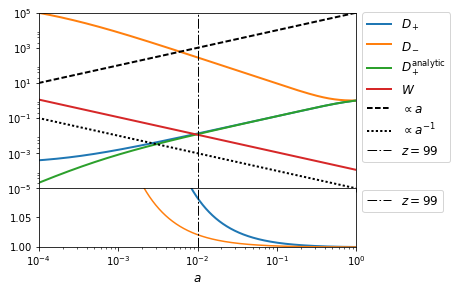

In [5]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(1.2*figwidth1,figheight1/0.75),sharex=True,
                              gridspec_kw = {'height_ratios':[3, 1]})

if False:
    aminexp = -13
    amin = 10**aminexp
    ymin = 10**(aminexp/2.)
    ymax = 10**(-aminexp/2.)
elif False:
    aminexp = -7
    amin = 10**aminexp
    ymin = 10**(aminexp)
    ymax = 10**(-aminexp)
else:
    aminexp = -4
    amin = 10**aminexp
    ymin = 10**(aminexp-1)
    ymax = 10**(-aminexp+1)
    

bg = cosmo['CDM'].get_background()

a = 1./(bg['z']+1)
H = bg['H [1/Mpc]']
grow = bg['grow']
grow_prime = bg['grow_prime']
#W= bg['Wronskian']
#decay= bg['decay']
decay= bg['bwdec']
decay_prime = bg['bwdec_prime']
D = bg['gr.fac. D']
f = bg['gr.fac. f']

W = grow*decay_prime-decay*grow_prime

grow_interp = interpolate.interp1d(a,grow)
decay_interp = interpolate.interp1d(a,decay)


#N=abs(grow[-1]/decay[-1])
ax1.loglog(a,grow/grow[-1],lw=lw,label=r'$D_+$')
ax1.loglog(a,decay/decay[-1],lw=lw,label=r'$D_-$')
ax1.loglog(a,D/D[-1],lw=lw,label=r'$D_+^\mathrm{analytic}$')
ax1.loglog(a,abs(W)/grow[-1]/decay[-1],lw=lw,label=r'$W$')

ax1.loglog(a,a*ymax,'k--',lw=lw,label=r'$\propto a$')
ax1.loglog(a,1./a*ymin,'k:',lw=lw,label=r'$\propto a^{-1}$')

ax2.semilogx(a,grow/grow[-1]/(D/D[-1]),lw=lw)
ax2.semilogx(a,grow/grow[-1]/D_hypergeom(a,cosmo['CDM']))
#ax2.semilogx(a,grow/grow[-1]/D_integral(a,cosmo['CDM']),'--',lw=5)


for ax in [ax1,ax2]:
    draw_vertical_redshift(cosmo['CDM'], ax, var='a',z=99)


lgd1 = ax1.legend(fontsize=fs,ncol=1,loc='upper left',
           bbox_to_anchor=(1.0, 1.035))

#lgd2 = ax2.legend([r'$D_+/D_+^\mathrm{analytic}$','$z=99$'],
#           fontsize=fs,ncol=1,loc='upper left',
#           bbox_to_anchor=(1.0, 1.08))
lgd2 = ax2.legend(fontsize=fs,ncol=1,loc='upper left',
           bbox_to_anchor=(1.0, 1.08))

#plt.ylim([1e-18,1e14])
#plt.ylim([1e-74,1e23])
ax1.set_xlim([10**aminexp,1]) 
ax2.set_xlabel(r'$a$',fontsize=fs)
ax1.set_ylim([ymin,ymax])
ax2.set_ylim([1.0,1.099])
#ax2.axhline(1,color='k')

for ax in [ax1,ax2]:
    draw_vertical_redshift(cosmo['CDM'], ax, var='a',z=99)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
fig.savefig('GrowingDecayingBackground.pdf',bbox_extra_artists=(lgd1,lgd2), bbox_inches='tight')

print 1./a[31850] -1

print grow[31850]



0.491906672239
6.69352734501e-10


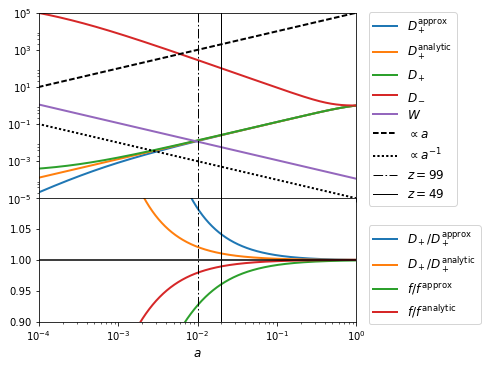

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(1.2*figwidth1,figheight1/(3./5.)),sharex=True,
                              gridspec_kw = {'height_ratios':[3, 2]})

if False:
    aminexp = -13
    amin = 10**aminexp
    ymin = 10**(aminexp/2.)
    ymax = 10**(-aminexp/2.)
elif False:
    aminexp = -7
    amin = 10**aminexp
    ymin = 10**(aminexp)
    ymax = 10**(-aminexp)
else:
    aminexp = -4
    amin = 10**aminexp
    ymin = 10**(aminexp-1)
    ymax = 10**(-aminexp+1)
    

bg = cosmo['CDM'].get_background()

a = 1./(bg['z']+1)
H = bg['H [1/Mpc]']
grow = bg['grow']
grow_prime = bg['grow_prime']
#W= bg['Wronskian']
#decay= bg['decay']
decay= bg['bwdec']
decay_prime = bg['bwdec_prime']
D = bg['gr.fac. D']
f = bg['gr.fac. f']

W = grow*decay_prime-decay*grow_prime

grow_interp = interpolate.interp1d(a,grow)
decay_interp = interpolate.interp1d(a,decay)
f_true = grow_prime/(grow*a*H)

ax1.loglog(a,D/D[-1],lw=lw,label=r'$D_+^\mathrm{approx}$')
ax1.loglog(a,D_hypergeom(a,cosmo['CDM']),lw=lw,label=r'$D_+^\mathrm{analytic}$')
ax1.loglog(a,grow/grow[-1],lw=lw,label=r'$D_+$')
ax1.loglog(a,decay/decay[-1],lw=lw,label=r'$D_-$')
ax1.loglog(a,abs(W)/grow[-1]/decay[-1],lw=lw,label=r'$W$')

ax1.loglog(a,a*ymax,'k--',lw=lw,label=r'$\propto a$')
ax1.loglog(a,1./a*ymin,'k:',lw=lw,label=r'$\propto a^{-1}$')

ax2.semilogx(a,grow/grow[-1]/(D/D[-1]),lw=lw,label=r'$D_+/D_+^\mathrm{approx}$')
ax2.semilogx(a,grow/grow[-1]/D_hypergeom(a,cosmo['CDM']),lw=lw,label=r'$D_+/D_+^\mathrm{analytic}$')
#ax2.semilogx(a,grow/grow[-1]/D_integral(a,cosmo['CDM']),'--',lw=5)
ax2.semilogx(a,f_true/f,lw=lw,label=r'$f/f^{\,\mathrm{ approx}}$')
ax2.semilogx(a,f_true/f_hypergeom(a,cosmo['CDM']),lw=lw,label=r'$f/f^{\,\mathrm{analytic}}$')


draw_vertical_redshift(cosmo['CDM'], ax1, var='a',z=99,label='$z=99$')
draw_vertical_redshift(cosmo['CDM'], ax1, var='a',z=49,label='$z=49$',ls='-')
draw_vertical_redshift(cosmo['CDM'], ax2, var='a',z=99,label=None)
draw_vertical_redshift(cosmo['CDM'], ax2, var='a',z=49,label=None,ls='-')

lgd1 = ax1.legend(fontsize=fs,ncol=1,loc='upper left',
           bbox_to_anchor=(1.02, 1.035))

#lgd2 = ax2.legend([r'$D_+/D_+^\mathrm{analytic}$','$z=99$'],
#           fontsize=fs,ncol=1,loc='upper left',
#           bbox_to_anchor=(1.0, 1.08))
lgd2 = ax2.legend(fontsize=fs,ncol=1,loc='upper left',
           bbox_to_anchor=(1.02, 0.83))

ax1.set_xlim([10**aminexp,1]) 
ax2.set_xlabel(r'$a$',fontsize=fs)
ax1.set_ylim([ymin,ymax])
ax2.set_ylim([0.9,1.099])

ax2.axhline(1,color='k')


fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
fig.savefig('GrowingDecayingBackground.pdf',bbox_extra_artists=(lgd1,lgd2), bbox_inches='tight')

print 1./a[31850] -1

print grow[31850]

0.491906672239
6.69352734501e-10


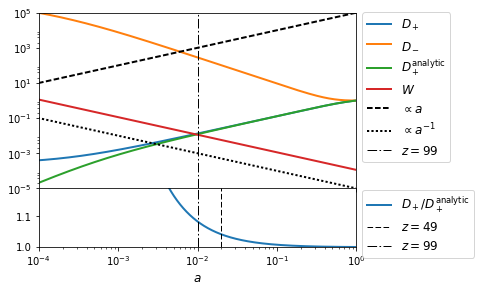

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(1.2*figwidth1,figheight1/0.75),sharex=True,
                              gridspec_kw = {'height_ratios':[3, 1]})

if False:
    aminexp = -13
    amin = 10**aminexp
    ymin = 10**(aminexp/2.)
    ymax = 10**(-aminexp/2.)
elif False:
    aminexp = -7
    amin = 10**aminexp
    ymin = 10**(aminexp)
    ymax = 10**(-aminexp)
else:
    aminexp = -4
    amin = 10**aminexp
    ymin = 10**(aminexp-1)
    ymax = 10**(-aminexp+1)
    

bg = cosmo['CDM'].get_background()

a = 1./(bg['z']+1)
H = bg['H [1/Mpc]']
grow = bg['grow']
grow_prime = bg['grow_prime']
#W= bg['Wronskian']
#decay= bg['decay']
decay= bg['bwdec']
decay_prime = bg['bwdec_prime']
D = bg['gr.fac. D']
f = bg['gr.fac. f']

W = grow*decay_prime-decay*grow_prime

grow_interp = interpolate.interp1d(a,grow)
decay_interp = interpolate.interp1d(a,decay)


#N=abs(grow[-1]/decay[-1])
ax1.loglog(a,grow/grow[-1],lw=lw)
ax1.loglog(a,decay/decay[-1],lw=lw)
ax1.loglog(a,D/D[-1],lw=lw)
ax1.loglog(a,abs(W)/grow[-1]/decay[-1],lw=lw)

ax1.loglog(a,a*ymax,'k--',lw=lw)
ax1.loglog(a,1./a*ymin,'k:',lw=lw)

ax2.semilogx(a,grow/grow[-1]/(D/D[-1]),lw=lw)
draw_vertical_redshift(cosmo['CDM'], ax2, var='a',z=49,ls='--')
for ax in [ax1,ax2]:
    draw_vertical_redshift(cosmo['CDM'], ax, var='a',z=99)


lgd1 = ax1.legend([r'$D_+$',r'$D_-$',r'$D_+^\mathrm{analytic}$',
                  r'$W$',r'$\propto a$',r'$\propto a^{-1}$','$z=99$'],
           fontsize=fs,ncol=1,loc='upper left',
           bbox_to_anchor=(1.0, 1.035))


lgd2 = ax2.legend([r'$D_+/D_+^\mathrm{analytic}$','$z=49$','$z=99$'],
           fontsize=fs,ncol=1,loc='upper left',
           bbox_to_anchor=(1.0, 1.08))

#plt.ylim([1e-18,1e14])
#plt.ylim([1e-74,1e23])
ax1.set_xlim([10**aminexp,1]) 
ax2.set_xlabel(r'$a$',fontsize=fs)
ax1.set_ylim([ymin,ymax])
ax2.set_ylim([1.0,1.19])
#ax2.axhline(1,color='k')


fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
fig.savefig('GrowingDecayingBackgroundOld.pdf',bbox_extra_artists=(lgd1,lgd2), bbox_inches='tight')

print 1./a[31850] -1

print grow[31850]



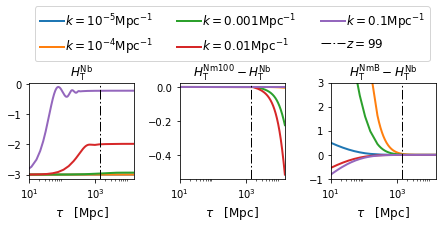

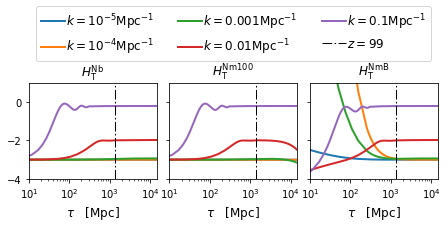

In [8]:
xselect = 'tau [Mpc]'
def dbl2str(k):
    if k<1e-3:
        exponent = int(np.log10(k))
        return '10^{'+str(exponent)+'}'
    else:
        return str(k)
for variant in ['diff','H_T']:
    if variant=='H_T':
        sharey=True
    else:
        sharey=False
    f, axes = plt.subplots(1,3,figsize=(figwidth2,0.8*figheight1),sharex=True,sharey=sharey)
    pt = cosmo['CDM'].get_perturbations()
    pts = pt['scalar']

    for idx, k in enumerate(k_out):
        pt = pts[idx]
        S1 = grow_interp(pt['a'])
        S2 = decay_interp(pt['a'])
        HTNb = pt['H_T_nm']+k*pt['L']
        if xselect=='z':
            x = 1./pt['a']-1
            xmin = 1e3
            xmax = 1e-2
        else:
            x = pt[xselect]
            xmin = min(x)
            xmax = max(x)
        axes[0].semilogx(x,HTNb,lw=2)
        y1 = -k*pt['L']
        y2 = (pt['CHT_grow']-pt['CHT_grow'][-1])*S1+(pt['CHT_decay']-pt['CHT_decay'][-1]+0.0)*S2+.0*HTNb
        if variant=='H_T':
            y1 = y1+HTNb
            y2 = y2+HTNb
        axes[1].semilogx(x,y1,lw=2)
        axes[2].semilogx(x,y2,lw=2)
    for ax in axes:
        draw_vertical_redshift(cosmo['CDM'], ax, var='tau',z=99)
    

    if False:
        axes[0].text(0.1,0.8,r'$H_\mathrm{T}^\mathrm{Nb}$',transform=axes[0].transAxes,fontsize=fs)
        axes[1].text(0.1,0.8,r'$H_\mathrm{T}^\mathrm{Nm100}-H_\mathrm{T}^\mathrm{Nb}$',transform=axes[1].transAxes,fontsize=fs)
        axes[2].text(0.1,0.8,r'$H_\mathrm{T}^\mathrm{NmFW}-H_\mathrm{T}^\mathrm{Nb}$',transform=axes[2].transAxes,fontsize=fs)
    else:
        axes[0].set_title(r'$H_\mathrm{T}^\mathrm{Nb}$',fontsize=fs)
        if variant=='diff':
            axes[1].set_title(r'$H_\mathrm{T}^\mathrm{Nm100}-H_\mathrm{T}^\mathrm{Nb}$',fontsize=fs)
            axes[2].set_title(r'$H_\mathrm{T}^\mathrm{NmB}-H_\mathrm{T}^\mathrm{Nb}$',fontsize=fs)
            axes[2].set_ylim([-1,3])
        else:
            axes[1].set_title(r'$H_\mathrm{T}^\mathrm{Nm100}$',fontsize=fs)
            axes[2].set_title(r'$H_\mathrm{T}^\mathrm{NmB}$',fontsize=fs)

    axes[0].set_xlim([xmin,xmax])    
    axes[0].set_xlim([10,xmax])    
    for j in range(3):
        axes[j].set_xlabel(r'$\tau\quad[\mathrm{Mpc}]$',fontsize=fs)
    
    leg = ['$k = '+dbl2str(kk)+r'\mathrm{Mpc}^{-1}$' for kk in k_out]
    lgd = axes[1].legend(leg+[r'$z=99$'],
                 fontsize=fs,loc='upper center',ncol=(len(k_out)+1)/2,
                bbox_to_anchor=(0.5, 1.85), handletextpad=0.1)
    
    
    f.tight_layout()
    if variant=='H_T':
        axes[0].set_ylim([-4,1])
        f.subplots_adjust(wspace=0.1)
    f.savefig('H_T_BS_'+variant+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

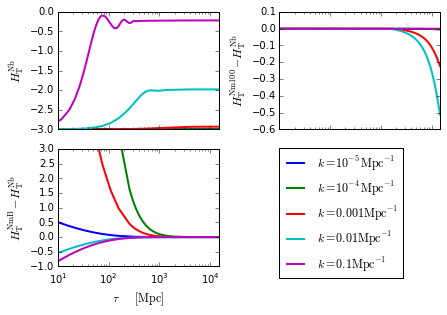

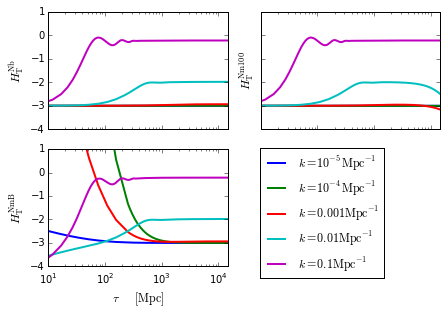

In [49]:
xselect = 'tau [Mpc]'
def dbl2str(k):
    if k<1e-3:
        exponent = int(np.log10(k))
        return '10^{'+str(exponent)+'}'
    else:
        return str(k)
for variant in ['diff','H_T']:
    if variant=='H_T':
        sharey=True
    else:
        sharey=False
    f, axes = plt.subplots(2,2,figsize=(figwidth2,figheight2),sharex=True,sharey=sharey)
    pt = cosmo['CDM'].get_perturbations()
    pts = pt['scalar']

    for idx, k in enumerate(k_out):
        pt = pts[idx]
        S1 = grow_interp(pt['a'])
        S2 = decay_interp(pt['a'])
        HTNb = pt['H_T_nm']+k*pt['L']
        if xselect=='z':
            x = 1./pt['a']-1
            xmin = 1e3
            xmax = 1e-2
        else:
            x = pt[xselect]
            xmin = min(x)
            xmax = max(x)
        axes[0,0].semilogx(x,HTNb,lw=2)
        y1 = -k*pt['L']
        y2 = (pt['CHT_grow']-pt['CHT_grow'][-1])*S1+(pt['CHT_decay']-pt['CHT_decay'][-1]+0.0)*S2+.0*HTNb
        if variant=='H_T':
            y1 = y1+HTNb
            y2 = y2+HTNb
        axes[0,1].semilogx(x,y1,lw=2)
        axes[1,0].semilogx(x,y2,lw=2)
    

    axes[0,0].set_ylabel(r'$H_\mathrm{T}^\mathrm{Nb}$',fontsize=fs)
    if variant=='diff':
        axes[0,1].set_ylabel(r'$H_\mathrm{T}^\mathrm{Nm100}-H_\mathrm{T}^\mathrm{Nb}$',fontsize=fs)
        axes[1,0].set_ylim([-1,3])
        axes[1,0].set_ylabel(r'$H_\mathrm{T}^\mathrm{NmB}-H_\mathrm{T}^\mathrm{Nb}$',fontsize=fs)
    else:
        axes[0,1].set_ylabel(r'$H_\mathrm{T}^\mathrm{Nm100}$',fontsize=fs)
        axes[1,0].set_ylabel(r'$H_\mathrm{T}^\mathrm{NmB}$',fontsize=fs)
    axes[1,1].set_axis_off()
    axes[0,0].set_xlim([10,xmax])    
    for j in range(2):
        axes[-1,j].set_xlabel(r'$\tau\quad[\mathrm{Mpc}]$',fontsize=fs)
    if variant=='H_T':
        axes[1,0].set_ylim([-4,1])
    lgd = axes[0,1].legend(['$k = '+dbl2str(kk)+r'\mathrm{Mpc}^{-1}$' for kk in k_out],
                 fontsize=fs,loc='lower left',ncol=1,
                bbox_to_anchor=(-0.04, -1.32))
    f.tight_layout()
    f.savefig('H_T_BS_'+variant+'2x2.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

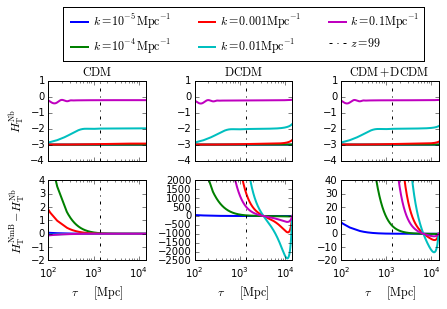

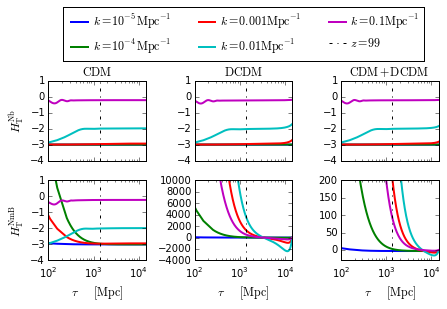

In [50]:
xselect = 'tau [Mpc]'
def dbl2str(k):
    if k<1e-3:
        exponent = int(np.log10(k))
        return '10^{'+str(exponent)+'}'
    else:
        return str(k)
for variant in ['diff','H_T']:
    
    f, axes = plt.subplots(2,3,figsize=(figwidth2,0.8*figheight2),sharex=True,sharey=False)
    
    yls = {'CDM':[-2,4],'DCDM':[-4000,1e4],'Mixed':[-30,200]}
    if variant=='H_T':
        yls['CDM'] = [-4,1]
    
    for j, M in enumerate(models):
        pt = cosmo[M].get_perturbations()
        pts = pt['scalar']

        for idx, k in enumerate(k_out):
            pt = pts[idx]
            S1 = grow_interp(pt['a'])
            S2 = decay_interp(pt['a'])
            HTNb = pt['H_T_nm']+k*pt['L']
            if xselect=='z':
                x = 1./pt['a']-1
                xmin = 1e3
                xmax = 1e-2
            else:
                x = pt[xselect]
                xmin = min(x)
                xmax = max(x)
            y1 = (pt['CHT_grow']-pt['CHT_grow'][-1])*S1+(pt['CHT_decay']-pt['CHT_decay'][-1]+0.0)*S2+.0*HTNb
            if variant=='H_T':
                y1 = y1+HTNb
            
            axes[0,j].semilogx(x,HTNb,lw=2)
            axes[1,j].semilogx(x,y1,lw=2)
        axes[0,j].set_ylim([-4,1])
        axes[1,j].set_ylim(yls[M])
        
    for j,M in enumerate(models):
        for ax in axes[:,j]:
            draw_vertical_redshift(cosmo[M], ax, var='tau',z=99)

            
    if variant=='diff':
        axes[0,0].set_title(r'$H_\mathrm{T}^\mathrm{NmB}-H_\mathrm{T}^\mathrm{Nb}$',fontsize=fs)
    else:
        axes[0,0].set_title(r'$H_\mathrm{T}^\mathrm{NmB}$',fontsize=fs)
        
    axes[0,0].set_ylabel(r'$H_\mathrm{T}^\mathrm{Nb}$',fontsize=fs)
    if variant=='H_T':
        axes[1,0].set_ylabel(r'$H_\mathrm{T}^\mathrm{NmB}$',fontsize=fs)
    else:
        axes[1,0].set_ylabel(r'$H_\mathrm{T}^\mathrm{NmB}-H_\mathrm{T}^\mathrm{Nb}$',fontsize=fs)
        axes[1,1].set_ylim([-2500,2000])
        axes[1,2].set_ylim([-20,40])
    
    for j in range(3):
        if models[j]=='Mixed':
            axes[0,j].set_title(r'$\mathrm{CDM+DCDM}$',fontsize=fs)
        else:
            axes[0,j].set_title(r'$\mathrm{'+models[j]+'}$',fontsize=fs)
    for j in range(3):
        axes[-1,j].set_xlabel(r'$\tau\quad[\mathrm{Mpc}]$',fontsize=fs)
        axes[-1,j].set_xlim([100,xmax])    
    
    leg = ['$k = '+dbl2str(kk)+r'\mathrm{Mpc}^{-1}$' for kk in k_out]
    lgd = axes[0,1].legend(leg+[r'$z = 99$'],
                 fontsize=fs,loc='upper center',ncol=(len(k_out)+1)/2,
                bbox_to_anchor=(0.5, 2.0), handletextpad=0.1)
    f.tight_layout()
    f.savefig('H_T_decaying_'+variant+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

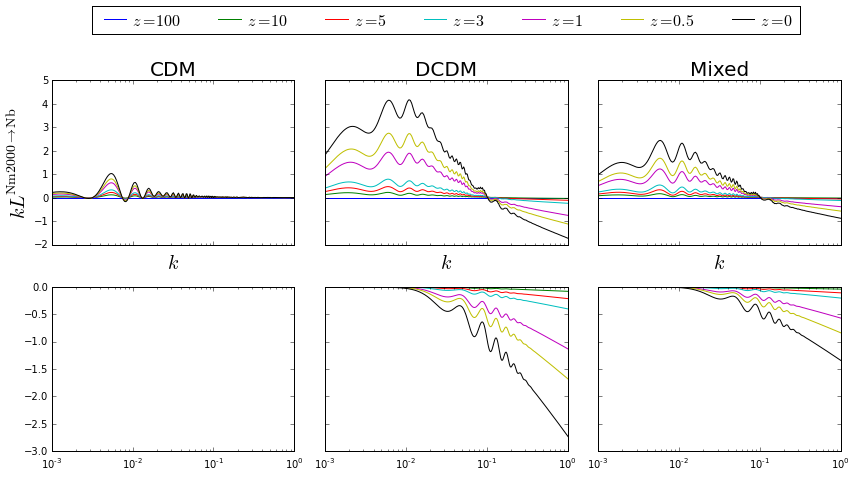

In [51]:
#these time evolution plots can be cool if devided by D+!
normalise = False

kvec = np.logspace(-5,1,300)
yls = {'CDM':[-1,3],'DCDM':[-4000,1e4],'Mixed':[-30,200]}
f, axes = plt.subplots(2,3,sharex=True,sharey='row',figsize=(12,6))
for j, M in enumerate(models):
    # Okay, here is how it is done:
    bg = cosmo[M].get_background()
    grow_interp = interpolate.interp1d(bg['z'],bg['grow']/bg['grow'][-1])
    
    for idx, z in enumerate(z_pk):
        tr = cosmo[M].get_transfer(z)
        k = tr['k (h/Mpc)']*cosmo[M].h()
        L = tr['L']
        massfunction = tr['L_prime']
        if normalise:
            axes[0,j].semilogx(k,k*L/grow_interp(z)) #/pt['CHT_grow'])
            axes[1,j].semilogx(k,massfunction/grow_interp(z)) #/pt['CHT_grow'])
        else:
            axes[0,j].semilogx(k,k*L) #/pt['CHT_grow'])
            axes[1,j].semilogx(k,massfunction) #/pt['CHT_grow'])
            
#    axes[0,j].set_ylim(yls[M])
#    axes[1,j].set_ylim([0,4])

axes[0,0].set_ylabel(r'$kL^{\mathrm{Nm2000}\rightarrow \mathrm{Nb}}$',fontsize=20)
#axes[1,0].set_ylabel(r'$M(k,z=0)$',fontsize=16)
for j in range(3):
    axes[0,j].set_title(models[j],fontsize=20)
    axes[0,j].set_xlabel(r'$k$',fontsize=20)
    axes[0,j].set_xlim([1e-3,1])    
lgd = axes[0,1].legend(['$z = '+"{:g}".format(zz)+r'$' for zz in z_pk],
                 fontsize=16,loc='upper center',ncol=len(z_pk),
                bbox_to_anchor=(0.5, 1.5), handletextpad=0.1)
f.tight_layout()
f.savefig('L_and_M_decaying.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

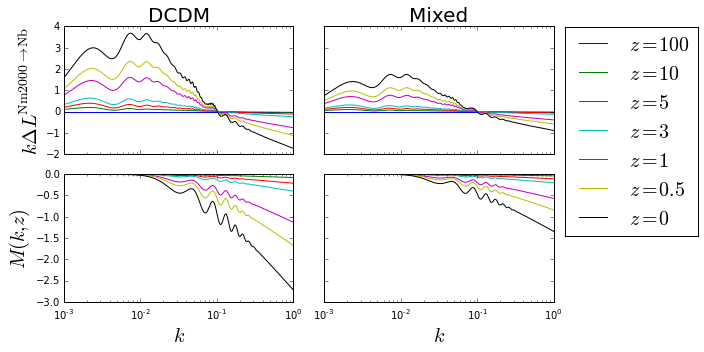

In [52]:
kvec = np.logspace(-5,1,300)
ref = 'CDM'
othermodels = [M for M in models if M!=ref]
yls = {'CDM':[-1,3],'DCDM':[-4000,1e4],'Mixed':[-30,200]}
f, axes = plt.subplots(2,2,sharex=True,sharey='row',figsize=(8,5))
for j, M in enumerate(othermodels):

    for idx, z in enumerate(z_pk):
        tr = cosmo[M].get_transfer(z)
        trref = cosmo[ref].get_transfer(z)
        k = tr['k (h/Mpc)']*cosmo[M].h()
        Lref_interp = interpolate.interp1d(trref['k (h/Mpc)']*cosmo[ref].h(),trref['L'],bounds_error=False,fill_value=np.NaN)
        L = tr['L']
        Lref = Lref_interp(k)
        mask = ~np.isnan(Lref)
        massfunction = tr['L_prime']
        axes[0,j].semilogx(k[mask],k[mask]*(L[mask]-Lref[mask]))
        axes[1,j].semilogx(k,massfunction)
#    axes[0,j].set_ylim(yls[M])
#    axes[1,j].set_ylim([0,4])

axes[0,0].set_ylabel(r'$k\Delta L^{\mathrm{Nm2000}\rightarrow \mathrm{Nb}}$',fontsize=20)
axes[1,0].set_ylabel(r'$M(k,z)$',fontsize=20)
for j in range(2):
    axes[0,j].set_title(othermodels[j],fontsize=20)
    axes[-1,j].set_xlabel(r'$k$',fontsize=20)
    axes[-1,j].set_xlim([1e-3,1])    
lgd = axes[0,1].legend(['$z = '+"{:g}".format(zz)+r'$' for zz in z_pk],
                 fontsize=20,loc='upper right',ncol=1,
                bbox_to_anchor=(1.67, 1.075))
f.tight_layout()
f.savefig('L_and_M_decaying2.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')


In [53]:
# Rerun with some contributions switched off:
ratios_cdm = {'CDM':1.,'DCDM':0.,'Mixed':0.5}
Gamma_dcdm = 6.
types = ['_dr_gamma','_only_dr']

for M in models:
    for T in types:
        if T=='_dr_gamma':
            switch_gamma = 1
        else:
            switch_gamma = 0
        cosmo[M+T] = Class()
        cosmo[M+T].set({'output':'mPk dTk lTk', 
           'z_pk':str(z_pk).strip('[]'),
           'k_output_values':str(k_out).strip('[]'),
           'a_init_nbody': 1./(z_init+1.),
           'switch_radiation_source':0,
                  'switch_dr_source':1,
           'switch_gamma':switch_gamma,
           'radiation_streaming_approximation':3,
           'ur_fluid_approximation':2,
           'l_max_g':100,
           'l_max_ur':100,
           'l_max_pol_g':100, 
           'reio_parametrization':'reio_none',
           'k_per_decade_for_pk':60,
           'k_per_decade_for_bao':120,
           'gauge' : 'Newtonian',
           'P_k_max_1/Mpc' : 1.1,
           'evolver':0,
           'tol_perturb_integration':0.000001,
           'tol_background_integration':1e-8,
           'back_integration_stepsize':1e-3,
           'perturb_sampling_stepsize':0.01,
           'tol_thermo_integration':1e-5,
           'Omega_cdm':0.24*ratios_cdm[M]+1e-6,
           'Omega_dcdmdr':0.24*(1-ratios_cdm[M]),
           'Gamma_dcdm':Gamma_dcdm,
                  'background_verbose':3})

        cosmo[M+T].compute()

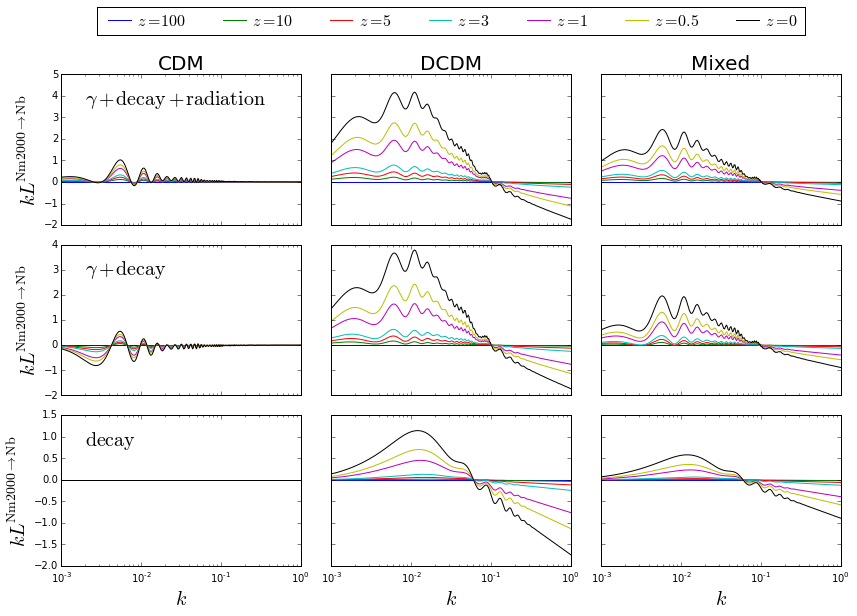

In [54]:
alltypes = ['']+types
kvec = np.logspace(-5,1,300)
yls = {'CDM':[-1,3],'DCDM':[-4000,1e4],'Mixed':[-30,200]}
f, axes = plt.subplots(len(alltypes),3,sharex=True,sharey='row',figsize=(12,8))
for j, M in enumerate(models):
    for n, T in enumerate(alltypes):
        MT = M+T
        for idx, z in enumerate(z_pk):
            tr = cosmo[MT].get_transfer(z)
            k = tr['k (h/Mpc)']*cosmo[MT].h()
            L = tr['L']
            axes[n,j].semilogx(k,k*L)
#        
for n in range(len(alltypes)):
    if alltypes[n]=='_dr_gamma':
        thestring = r'$\gamma + \mathrm{decay}$'
    elif alltypes[n]=='_only_dr':
        thestring = r'$\mathrm{decay}$'
    else:
        thestring = r'$\gamma + \mathrm{decay}+\mathrm{radiation}$'
    axes[n,0].set_ylabel(r'$kL^{\mathrm{Nm2000}\rightarrow \mathrm{Nb}}$',fontsize=20)
    axes[n,0].text(0.1,0.8,thestring,transform=axes[n,0].transAxes,fontsize=20)
axes[0,0].set_ylabel(r'$kL^{\mathrm{Nm2000}\rightarrow \mathrm{Nb}}$',fontsize=20)
#axes[1,0].set_ylabel(r'$M(k,z=0)$',fontsize=16)
for j in range(3):
    axes[0,j].set_title(models[j],fontsize=20)
    axes[-1,j].set_xlabel(r'$k$',fontsize=20)
    axes[-1,j].set_xlim([1e-3,1])    
lgd = axes[0,1].legend(['$z = '+"{:g}".format(zz)+r'$' for zz in z_pk],
                 fontsize=16,loc='upper center',ncol=len(z_pk),
                bbox_to_anchor=(0.5, 1.5), handletextpad=0.1)
f.tight_layout()
f.savefig('L_and_M_decaying3.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [55]:
#Rerun for different z_init:
models = ['CDM','DCDM','Mixed']
ratios_cdm = {'CDM':1.,'DCDM':0.,'Mixed':0.5}
Gamma_dcdm = 6.

#z_pk = [200.0,100.0,75.0,50.0,10.0,5.0,0.0]
z_pk = [100.0,10.0,5.0,3.0,1.0,0.5,0.0]
k_out = [0.00001,0.0001, 0.001, 0.01,.1]
z_init_vec = [100.,50.,25.0,10.0,5.0]
cosmo2 = {}
allmodels = [M+'-'+"{:d}".format(nn) for M in models for nn in range(len(z_init_vec))]
for M in allmodels:
    index_z = int(M.split('-')[-1])
    z_init = z_init_vec[index_z]
    print M, z_init
    cosmo2[M] = Class()
    cosmo2[M].set({'output':'mPk dTk lTk', 
           'z_pk':str(z_pk).strip('[]'),
           'k_output_values':str(k_out).strip('[]'),
           'a_init_nbody': 1./(z_init+1.),
           'switch_radiation_source':1,
                  'switch_dr_source':1,
           'switch_gamma':1,
           'radiation_streaming_approximation':3,
           'ur_fluid_approximation':2,
           'l_max_g':100,
           'l_max_ur':100,
           'l_max_pol_g':100, 
           'reio_parametrization':'reio_none',
           'k_per_decade_for_pk':60,
           'k_per_decade_for_bao':120,
           'gauge' : 'Newtonian',
           'P_k_max_1/Mpc' : 1.1,
           'evolver':0,
           'tol_perturb_integration':0.000001,
           'tol_background_integration':1e-8,
           'back_integration_stepsize':1e-3,
           'perturb_sampling_stepsize':0.01,
           'tol_thermo_integration':1e-5,
           'Omega_cdm':0.24*ratios_cdm[M.split('-')[0]]+1e-6,
           'Omega_dcdmdr':0.24*(1-ratios_cdm[M.split('-')[0]]),
           'Gamma_dcdm':Gamma_dcdm,
                  'background_verbose':3
#           'N_ur':0.0,
#           'YHe':0.25,
#           'Omega_b':0.05,
#           'Omega_cdm':0.95
            })
#    for key, val in cosmo2[M].pars.iteritems():
#        print key,' = ',val
    cosmo2[M].compute()

CDM-0 100.0
CDM-1 50.0
CDM-2 25.0
CDM-3 10.0
CDM-4 5.0
DCDM-0 100.0
DCDM-1 50.0
DCDM-2 25.0
DCDM-3 10.0
DCDM-4 5.0
Mixed-0 100.0
Mixed-1 50.0
Mixed-2 25.0
Mixed-3 10.0
Mixed-4 5.0


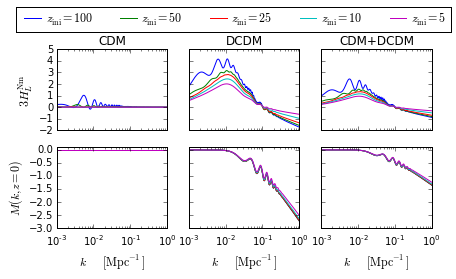

In [56]:
kvec = np.logspace(-5,1,300)
yls = {'CDM':[-1,3],'DCDM':[-4000,1e4],'Mixed':[-30,200]}
f, axes = plt.subplots(2,3,sharex=True,sharey='row',figsize=(figwidth2,0.8*figheight2))
for j,M in enumerate(models):
    for idx, z in enumerate(z_init_vec):
        mod = M+'-'+str(idx)
        tr = cosmo2[mod].get_transfer(0.)
        k = tr['k (h/Mpc)']*cosmo2[mod].h()
        L = tr['L']
        massfunction = tr['L_prime']
        axes[0,j].semilogx(k,k*L)
        axes[-1,j].semilogx(k,massfunction)
    #axes[0,j].set_ylim([-1,5]) 
    #axes[-1,j].set_ylim([-1,5])

for j in range(1):
#    axes[j,0].set_ylabel(r'$kL^{\mathrm{Nm2000}\rightarrow \mathrm{Nb}}$',fontsize=20)
    axes[j,0].set_ylabel(r'$3H_L^{\mathrm{Nm}}$',fontsize=fs)
axes[-1,0].set_ylabel(r'$M(k,z=0)$',fontsize=fs)
    #axes[1,0].set_ylabel(r'$M(k,z=0)$',fontsize=16)
for j in range(3):
    if models[j]=='Mixed':
        axes[0,j].set_title('CDM+DCDM',fontsize=fs)
    else:
        axes[0,j].set_title(models[j],fontsize=fs)
    axes[-1,j].set_xlabel(r'$k\quad [\mathrm{Mpc}^{-1}]$',fontsize=fs)
    axes[-1,j].set_xlim([1e-3,1])    
lgd = axes[0,1].legend(['$z_\mathrm{ini} = '+"{:g}".format(zz)+r'$' for zz in z_init_vec],
                 fontsize=fs,loc='upper center',ncol=len(z_init_vec),
                bbox_to_anchor=(0.4, 1.6), handletextpad=0.1)
axes[-1,1].set_ylim([-3,0.1])    
f.tight_layout()
f.subplots_adjust(wspace=0.2)
f.savefig('L_and_M_decaying4.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

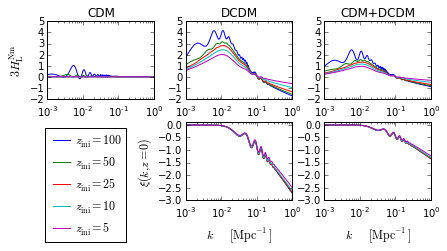

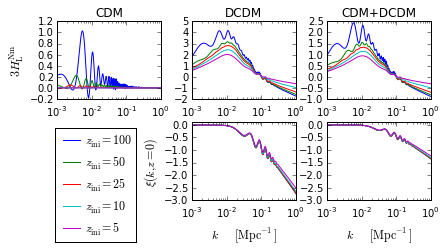

In [64]:
for variant in ['a','b']:
    kvec = np.logspace(-5,1,300)
    yls = {'CDM':[-1,3],'DCDM':[-4000,1e4],'Mixed':[-30,200]}
    #f, axes = plt.subplots(2,3,sharex=True,sharey='row',figsize=(figwidth2,0.8*figheight2))
    f = plt.figure(figsize=(figwidth2,0.8*figheight2))
    axes = np.zeros((2,3),dtype=object)
    axes[0,0] = f.add_subplot(2, 3, 1)
    for j in range(1,3):
        if variant=='a':
            axes[0,j] = f.add_subplot(2, 3, j+1, sharex=axes[0,0],sharey=axes[0,0])
        if variant=='b':
            axes[0,j] = f.add_subplot(2, 3, j+1, sharex=axes[0,0])
    axes[1,1] = f.add_subplot(2, 3, 5, sharex=axes[0,0])
    axes[1,2] = f.add_subplot(2, 3, 6, sharex=axes[0,0],sharey=axes[1,1])

    for j,M in enumerate(models):
        for idx, z in enumerate(z_init_vec):
            mod = M+'-'+str(idx)
            tr = cosmo2[mod].get_transfer(0.)
            k = tr['k (h/Mpc)']*cosmo2[mod].h()
            L = tr['L']
            massfunction = tr['L_prime']
            axes[0,j].semilogx(k,k*L)
            if j>0:
                axes[-1,j].semilogx(k,massfunction)
    
    
    for j in range(1):
        axes[j,0].set_ylabel(r'$3H_\mathrm{L}^{\mathrm{Nm}}$',fontsize=fs)
    axes[-1,1].set_ylabel(r'$\xi(k,z=0)$',fontsize=fs)
    for j in range(3):
        if models[j]=='Mixed':
            axes[0,j].set_title('CDM+DCDM',fontsize=fs)
        else:
            axes[0,j].set_title(models[j],fontsize=fs)
    
        if j>0:
            idx=-1
        else:
            idx=0
        if j>0:
            axes[idx,j].set_xlabel(r'$k\quad [\mathrm{Mpc}^{-1}]$',fontsize=fs)
        axes[idx,j].set_xlim([1e-3,1])  
    leg = ['$z_\mathrm{ini} = '+"{:g}".format(zz)+r'$' for zz in z_init_vec]
    lgd = axes[0,0].legend(leg,
                 fontsize=fs,loc='upper left',ncol=1,bbox_to_anchor=(-0.08, -0.3), handletextpad=0.1)
    axes[-1,1].set_ylim([-3,0.1])    
    f.tight_layout()
    f.subplots_adjust(wspace=0.3,hspace=0.3)
    f.savefig('L_and_M_decaying5'+variant+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [4]:
#Kazuya plot
models = ['CDM','DCDM','Mixed']
ratios_cdm = {'CDM':1.,'DCDM':0.,'Mixed':0.5}
Gamma_dcdm = 6.

#z_pk = [200.0,100.0,75.0,50.0,10.0,5.0,0.0]
z_pk = [100.0,10.0,5.0,3.0,1.0,0.5,0.0]
k_out = [0.00001,0.0001, 0.001, 0.01,.1]
z_init = 0.
cosmo3 = {}
for M in models:
    print M
    cosmo3[M] = Class()
    cosmo3[M].set({'output':'mPk dTk lTk tCl', 
           'z_pk':str(z_pk).strip('[]'),
           'k_output_values':str(k_out).strip('[]'),
           'a_init_nbody': 1./(z_init+1.),
           'radiation_streaming_approximation':3,
           'ur_fluid_approximation':2,
           'l_max_g':100,
           'l_max_ur':100,
           'l_max_pol_g':100, 
           'reio_parametrization':'reio_none',
           'k_per_decade_for_pk':60,
           'k_per_decade_for_bao':120,
           'gauge' : 'Newtonian',
           'P_k_max_1/Mpc' : 1.1,
           'evolver':0,
           'tol_perturb_integration':0.000001,
           'tol_background_integration':1e-8,
           'back_integration_stepsize':1e-3,
           'perturb_sampling_stepsize':0.01,
           'tol_thermo_integration':1e-5,
           'Omega_cdm':0.24*ratios_cdm[M]+1e-6,
           'Omega_dcdmdr':0.24*(1-ratios_cdm[M]),
           'Gamma_dcdm':Gamma_dcdm,
                  'background_verbose':3,
                  'start_sources_at_tau_c_over_tau_h':0.004,
                  'start_small_k_at_tau_c_over_tau_h':0.000015
            })
#for key, val in cosmo.pars.iteritems():
#    print key,' = ',val
    cosmo3[M].compute()

CDM
DCDM
Mixed


True
True
True


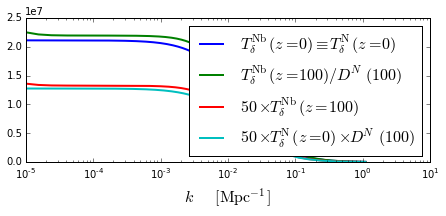

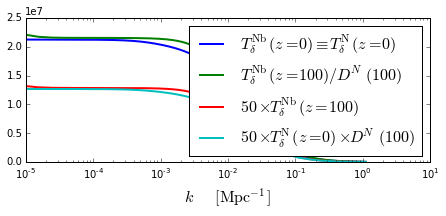

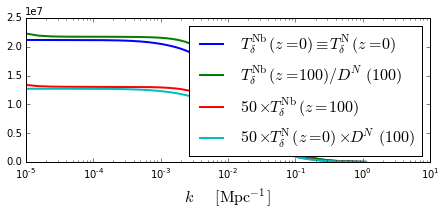

In [11]:
fs=16
for M in models:
    plt.figure(figsize=(figwidth2,figheight1))
    z=100.
    tr100 = cosmo3[M].get_transfer(z)
    tr0 = cosmo3[M].get_transfer(0.)
    deltaNb100 = tr100['delta_Nb']
    deltaNb0 = tr0['delta_Nb']
    deltaN0 = deltaNb0
    bg = cosmo[M].get_background()
    grow_interp = interpolate.interp1d(bg['z'],bg['gr.fac. D']/bg['gr.fac. D'][-1])
    deltaN100 = deltaN0*grow_interp(z)
    deltaNb0_Newtonian = deltaNb100/grow_interp(z)

    k0 = tr0['k (h/Mpc)']*cosmo[M].h()
    k1 = tr100['k (h/Mpc)']*cosmo[M].h()

    k2 = k0*k0
    print np.allclose(k0,k1)

    plt.semilogx(k0,-deltaNb0/k2,label=r'$T_\delta^\mathrm{Nb}(z=0)\equiv T_\delta^\mathrm{N}(z=0)$',lw=lw)
    plt.semilogx(k0,-deltaNb0_Newtonian/k2,label=r'$T_\delta^\mathrm{Nb}(z=100)/D^N(100)$',lw=lw)
    plt.semilogx(k0,-50*deltaNb100/k2,label=r'$50 \times T_\delta^\mathrm{Nb}(z=100)$',lw=lw)
    plt.semilogx(k0,-50*deltaN100/k2,label=r'$50 \times T_\delta^\mathrm{N}(z=0)\times D^N(100)$',lw=lw)
    plt.xlabel(r'$k\quad [\mathrm{Mpc}^{-1}]$',fontsize=fs)
    lgd=plt.legend(fontsize=fs)
    plt.xlim([1e-5,10.0])
    plt.tight_layout()
    plt.savefig('Kazuya_'+M+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

True
1.0456047694 1.1257640821
[0.31, 0.83] 0.52
[0.37, 0.91] 0.54


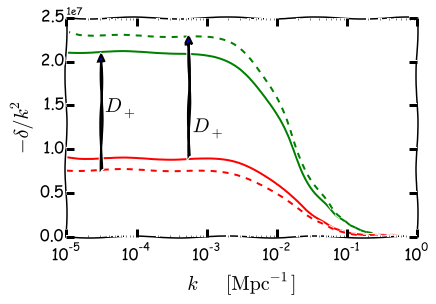

In [12]:
fs = 20
delta_y = 1e6
for M in ['CDM']:
    with plt.xkcd():
        f, ax = plt.subplots(1,1,figsize=(figwidth2,figheight2))
        ax.tick_params(axis='both', which='major', labelsize=16)
        z=100.
        tr100 = cosmo3[M].get_transfer(z)
        tr0 = cosmo3[M].get_transfer(0.)
        deltaNb100 = tr100['delta_Nb']
        deltaNb0 = tr0['delta_Nb']
        deltaN0 = deltaNb0
        bg = cosmo[M].get_background()
        grow_interp = interpolate.interp1d(bg['z'],bg['gr.fac. D']/bg['gr.fac. D'][-1])
        deltaN100 = deltaN0*grow_interp(z)
        deltaNb0_Newtonian = deltaNb100/grow_interp(z)

        k0 = tr0['k (h/Mpc)']*cosmo[M].h()
        k1 = tr100['k (h/Mpc)']*cosmo[M].h()

        k2 = k0*k0
        print np.allclose(k0,k1)
        idx=20
        fudge1 = 1-delta_y/(deltaNb0_Newtonian[idx]/k2[idx])
        fudge2 = 1-delta_y/(30*deltaNb100[idx]/k2[idx])
        print fudge1,fudge2
        

        ax.semilogx(k0,-deltaNb0/k2,label=r'$T_\delta^\mathrm{Nb}(z=0)\equiv T_\delta^\mathrm{N}(z=0)$',lw=lw,color='g')
        ax.semilogx(k0,-fudge1*deltaNb0_Newtonian/k2,label=r'$T_\delta^\mathrm{Nb}(z=100)/D^N(100)$',lw=lw,color='g',ls='--')
        ax.semilogx(k0,-30*fudge2*deltaNb100/k2,label=r'$30 \times T_\delta^\mathrm{Nb}(z=100)$',lw=lw,color='r')
        ax.semilogx(k0,-30*deltaN100/k2,label=r'$30 \times T_\delta^\mathrm{N}(z=0)\times D^N(100)$',lw=lw,color='r',ls='--')
        ax.set_xlabel(r'$k\quad [\mathrm{Mpc}^{-1}]$',fontsize=fs)
        ax.set_ylabel(r'$-\delta/k^2$',fontsize=fs)
        #plt.legend(fontsize=fs)
        ax.set_xlim([1e-5,1.0])
        
        x = [[.1,.1],[.35,.35]]
        #y = [[0.82,0.31],[0.35,0.91]]
        y = [[0.31,0.83],[0.37,0.91]]
        
        for i in range(2):
            x0 = x[i]
            y0 = y[i]
            dx = 0
            dy = y0[1]-y0[0]
            print y0,dy
            ax.arrow(x0[0],y0[0],dx,dy,
#                      width=lw, head_width=0.2,head_length=0.2,
                      transform=ax.transAxes, length_includes_head=True,zorder=100,lw=lw)
#            ax.text(x0[0]+0.01,y0[0]+(0.5-i*0.3)*dy,r'$D_+^\mathrm{analytic}$',transform=ax.transAxes,fontsize=fs)
            ax.text(x0[0]+0.01,y0[0]+(0.5-i*0.3)*dy,r'$D_+$',transform=ax.transAxes,fontsize=fs)
        
        f.tight_layout()
        f.savefig('Kazuya_'+M+'_xkcd.pdf', bbox_inches='tight')

True
1.0456047694 1.1257640821
[0.31, 0.83] 0.52
[0.37, 0.91] 0.54


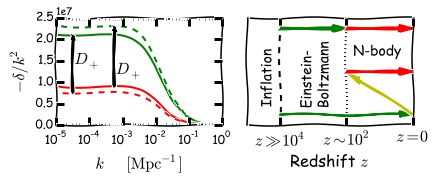

In [13]:
fs = 16
fssmall = 14
delta_y = 1e6
for M in ['CDM']:
    with plt.xkcd():
        f, [ax,ax2] = plt.subplots(1,2,figsize=(figwidth2,0.9*figheight1))
        ax.tick_params(axis='both', which='major', labelsize=12)
        z=100.
        tr100 = cosmo3[M].get_transfer(z)
        tr0 = cosmo3[M].get_transfer(0.)
        deltaNb100 = tr100['delta_Nb']
        deltaNb0 = tr0['delta_Nb']
        deltaN0 = deltaNb0
        bg = cosmo[M].get_background()
        grow_interp = interpolate.interp1d(bg['z'],bg['gr.fac. D']/bg['gr.fac. D'][-1])
        deltaN100 = deltaN0*grow_interp(z)
        deltaNb0_Newtonian = deltaNb100/grow_interp(z)

        k0 = tr0['k (h/Mpc)']*cosmo[M].h()
        k1 = tr100['k (h/Mpc)']*cosmo[M].h()

        k2 = k0*k0
        print np.allclose(k0,k1)
        idx=20
        fudge1 = 1-delta_y/(deltaNb0_Newtonian[idx]/k2[idx])
        fudge2 = 1-delta_y/(30*deltaNb100[idx]/k2[idx])
        print fudge1,fudge2
        

        ax.semilogx(k0,-deltaNb0/k2,label=r'$T_\delta^\mathrm{Nb}(z=0)\equiv T_\delta^\mathrm{N}(z=0)$',lw=lw,color='g')
        ax.semilogx(k0,-fudge1*deltaNb0_Newtonian/k2,label=r'$T_\delta^\mathrm{Nb}(z=100)/D^N(100)$',lw=lw,color='g',ls='--')
        ax.semilogx(k0,-30*fudge2*deltaNb100/k2,label=r'$30 \times T_\delta^\mathrm{Nb}(z=100)$',lw=lw,color='r')
        ax.semilogx(k0,-30*deltaN100/k2,label=r'$30 \times T_\delta^\mathrm{N}(z=0)\times D^N(100)$',lw=lw,color='r',ls='--')
        ax.set_xlabel(r'$k\quad [\mathrm{Mpc}^{-1}]$',fontsize=fs)
        ax.set_ylabel(r'$-\delta/k^2$',fontsize=fs)
        #plt.legend(fontsize=fs)
        ax.set_xlim([1e-5,1.0])
        
        x = [[.1,.1],[.35,.35]]
        #y = [[0.82,0.31],[0.35,0.91]]
        y = [[0.31,0.83],[0.37,0.91]]
        
        for i in range(2):
            x0 = x[i]
            y0 = y[i]
            dx = 0
            dy = y0[1]-y0[0]
            print y0,dy
            ax.arrow(x0[0],y0[0],dx,dy,
#                      width=lw, head_width=0.2,head_length=0.2,
                      transform=ax.transAxes, length_includes_head=True,zorder=100,lw=lw)
#            ax.text(x0[0]+0.01,y0[0]+(0.5-i*0.3)*dy,r'$D_+^\mathrm{analytic}$',transform=ax.transAxes,fontsize=fs)
            ax.text(x0[0]+0.01,y0[0]+(0.5-i*0.3)*dy,r'$D_+$',transform=ax.transAxes,fontsize=fs)

#        ax2.plot(np.linspace(250,0,100),np.linspace(0,1,100))
        ax2.axvline(200,linestyle='--',color='k')
        ax2.axvline(100,linestyle=':',color='k')
        ax2.set_xlim([250,0])
        ax2.set_xticks([200,100,0])
        ax2.set_xticklabels([r'$z\gg 10^4$',r'$z\sim 10^2$',r'$z=0$'],fontsize=fs)
        ax2.set_yticks([])
        ax2.set_yticklabels([])
        ax2.text(230,0.6,'Inflation',fontsize=fssmall,rotation=90)
        ax2.text(170,0.5,'Einstein-\nBoltzmann',fontsize=fssmall,rotation=90)
        #ax2.text(60,0.6,'N-body',fontsize=fssmall,rotation=90)
        ax2.text(90,0.65,'N-body',fontsize=fssmall,rotation=0)
        
        ax2.arrow(200,0.9,-100,0,length_includes_head=True,zorder=100,lw=lw,head_width=0.05,head_length=20,color='g')
        ax2.arrow(100,0.9,-100,0,length_includes_head=True,zorder=100,lw=lw,head_width=0.05,head_length=20,color='r')
        
        
        ax2.arrow(200,0.1,-200,0,length_includes_head=True,zorder=100,lw=lw,head_width=0.05,head_length=20,color='g')
        ax2.arrow(0,0.1,100,0.4,length_includes_head=True,zorder=100,lw=lw,head_width=0.05,head_length=20,color='y')
        ax2.arrow(100,0.5,-100,0,length_includes_head=True,zorder=100,lw=lw,head_width=0.05,head_length=20,color='r')
        ax2.set_xlabel('Redshift $z$',fontsize=fs)
    
    
        f.tight_layout()
        f.savefig('Kazuya_'+M+'_xkcd2.pdf', bbox_inches='tight')

True
1.0456047694 1.1257640821


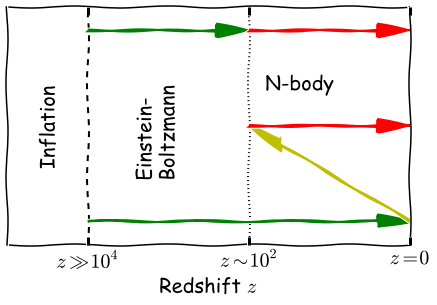

In [17]:
fs = 20
fssmall=fs
delta_y = 1e6
for M in ['CDM']:
    with plt.xkcd():
        f, ax2 = plt.subplots(1,1,figsize=(figwidth2,figheight2))
        #f, [ax,ax2] = plt.subplots(1,2,figsize=(figwidth2,0.9*figheight1))
        z=100.
        tr100 = cosmo3[M].get_transfer(z)
        tr0 = cosmo3[M].get_transfer(0.)
        deltaNb100 = tr100['delta_Nb']
        deltaNb0 = tr0['delta_Nb']
        deltaN0 = deltaNb0
        bg = cosmo[M].get_background()
        grow_interp = interpolate.interp1d(bg['z'],bg['gr.fac. D']/bg['gr.fac. D'][-1])
        deltaN100 = deltaN0*grow_interp(z)
        deltaNb0_Newtonian = deltaNb100/grow_interp(z)

        k0 = tr0['k (h/Mpc)']*cosmo[M].h()
        k1 = tr100['k (h/Mpc)']*cosmo[M].h()

        k2 = k0*k0
        print np.allclose(k0,k1)
        idx=20
        fudge1 = 1-delta_y/(deltaNb0_Newtonian[idx]/k2[idx])
        fudge2 = 1-delta_y/(30*deltaNb100[idx]/k2[idx])
        print fudge1,fudge2
        

        #ax2.plot(np.linspace(250,0,100),np.linspace(0,1,100))
        ax2.axvline(200,linestyle='--',color='k')
        ax2.axvline(100,linestyle=':',color='k')
        ax2.set_xlim([250,0])
        ax2.set_xticks([200,100,0])
        ax2.set_xticklabels([r'$z\gg 10^4$',r'$z\sim 10^2$',r'$z=0$'],fontsize=fs)
        ax2.set_yticks([])
        ax2.set_yticklabels([])
        ax2.text(230,0.6,'Inflation',fontsize=fssmall,rotation=90)
        ax2.text(170,0.5,'Einstein-\nBoltzmann',fontsize=fssmall,rotation=90)
        #ax2.text(60,0.6,'N-body',fontsize=fssmall,rotation=90)
        ax2.text(90,0.65,'N-body',fontsize=fssmall,rotation=0)
        
        ax2.arrow(200,0.9,-100,0,length_includes_head=True,zorder=100,lw=lw,head_width=0.05,head_length=20,color='g')
        ax2.arrow(100,0.9,-100,0,length_includes_head=True,zorder=100,lw=lw,head_width=0.05,head_length=20,color='r')
        
        
        ax2.arrow(200,0.1,-200,0,length_includes_head=True,zorder=100,lw=lw,head_width=0.05,head_length=20,color='g')
        ax2.arrow(0,0.1,100,0.4,length_includes_head=True,zorder=100,lw=lw,head_width=0.05,head_length=20,color='y')
        ax2.arrow(100,0.5,-100,0,length_includes_head=True,zorder=100,lw=lw,head_width=0.05,head_length=20,color='r')
        ax2.set_xlabel('Redshift $z$',fontsize=fs)
    
    
        f.tight_layout()
        f.savefig('Kazuya_'+M+'_xkcd2.pdf', bbox_inches='tight')

In [5]:
csm = cosmo['CDM']
print csm.pars

{'z_pk': '100.0, 10.0, 5.0, 3.0, 1.0, 0.5, 0.0', 'tol_background_integration': 1e-08, 'perturb_sampling_stepsize': 0.01, 'k_per_decade_for_bao': 120, 'P_k_max_1/Mpc': 1.1, 'tol_thermo_integration': 1e-05, 'k_per_decade_for_pk': 60, 'gauge': 'Newtonian', 'switch_gamma': 1, 'reio_parametrization': 'reio_none', 'back_integration_stepsize': 0.001, 'Gamma_dcdm': 6.0, 'ur_fluid_approximation': 2, 'evolver': 0, 'radiation_streaming_approximation': 3, 'switch_radiation_source': 1, 'switch_dr_source': 1, 'k_output_values': '1e-05, 0.0001, 0.001, 0.01, 0.1', 'start_small_k_at_tau_c_over_tau_h': 1.5e-05, 'l_max_pol_g': 100, 'Omega_cdm': 0.240001, 'tol_perturb_integration': 1e-06, 'a_init_nbody': 0.009900990099009901, 'start_sources_at_tau_c_over_tau_h': 0.004, 'background_verbose': 3, 'Omega_dcdmdr': 0.0, 'output': 'mPk dTk lTk', 'l_max_ur': 100, 'l_max_g': 100}


In [9]:
print csm.h()
print csm.Omega0_m()
bg = csm.get_background()
print bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
print (bg['(.)rho_cdm'][-1]+bg['(.)rho_b'][-1])/bg['(.)rho_crit'][-1]


0.67556
0.288276420889
0.711631907754
0.288276420889
